# Language Classification

This notebook contains the code for a CNN that classifies spoken language from Mel spectrograms. There is additional code for other types of models (only some working), but the best results are obtained using the model saved as "cnn" in the training segment.

Used as reference:

https://github.com/pietz/language-recognition/blob/master/Language%20Classifier.ipynb

https://github.com/sergeyvilov/MCV-spoken-language-recognition/blob/master/audio_models.py

https://towardsdatascience.com/spoken-language-recognition-on-mozilla-common-voice-part-ii-models-b32780ea1ee4

https://towardsdatascience.com/spoken-language-recognition-on-mozilla-common-voice-part-i-3f5400bbbcd8

https://github.com/zkmkarlsruhe/language-identification/tree/main

## Data Loading


In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tqdm import tqdm

### Languages to Detect


In [16]:
np.random.seed(1)
from languages import LANGUAGES

langs = ["de", "en", "es", "fr", "it"]
# langs = ["en", "fr"]
lang_nums = {lang: index for index, lang in enumerate(langs)}

num_to_lang = {v: k for k, v in lang_nums.items()}
for lang in langs:
    print(LANGUAGES[lang])

# IMAGE_DIMENSIONS = (20, 250, 1)
IMAGE_DIMENSIONS = (13, 1000, 1)

English
French


### Load Spectrograms


In [17]:
def load_images_from_path(path, label, num_images=1000, shuffle=True):
    images = []
    labels = []

    count = 0
    files = os.listdir(path)
    if shuffle:
        files = np.random.choice(files, num_images, replace=False)
    else:
        files = files[:num_images]
    for file in tqdm(files):
        # print(f"{count} - {file}")
        if count >= num_images:
            break
        try:
            img = image.img_to_array(
                image.load_img(
                    os.path.join(path, file),
                    target_size=(IMAGE_DIMENSIONS[0], IMAGE_DIMENSIONS[1], 3),
                ).convert("L")
            )
            img = img.reshape(IMAGE_DIMENSIONS)
            # from 255 to 0-1
            img = img / 255
            images.append(img)
            labels.append((label))
            count += 1
        except Exception as e:
            print(f"Error loading image: {file}")
            print(e)

    return images, labels


def show_images(images, label):
    fig, axes = plt.subplots(
        1, 8, figsize=(20, 20), subplot_kw={"xticks": [], "yticks": []}
    )

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        # ax.imshow(images[i] / 255)
        ax.set_title(LANGUAGES[num_to_lang[labels[i]]])  # Set the title for the subplot

English


100%|██████████| 10000/10000 [00:03<00:00, 2711.49it/s]


(20, 250, 1)
French


100%|██████████| 10000/10000 [00:03<00:00, 3038.76it/s]


(20, 250, 1)


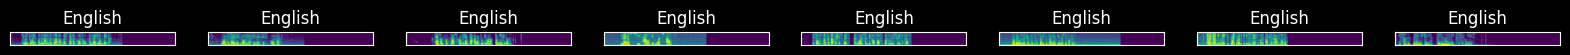

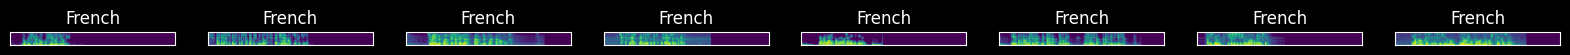

In [5]:
mm = []
y = []
NUM_IMGS = 92_740
# NUM_IMGS = 20
# NUM_IMGS = 50_000
# NUM_IMGS = 10_000

for lang in langs:
    print(LANGUAGES[lang])
    path = f"data/spectrogram/{lang}_train_20_mels/"
    images, labels = load_images_from_path(
        path, lang_nums[lang], num_images=NUM_IMGS, shuffle=False
    )
    mm += images
    y += labels
    print(images[0].shape)
    show_images(images, labels)

## Data Splitting


In [6]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [7]:
tf.random.set_seed(1)

x_train, x_test, y_train, y_test = train_test_split(
    mm, y, stratify=y, test_size=0.2, random_state=0, shuffle=True
)

x_train_arr = np.array(x_train)
x_test_arr = np.array(x_test)

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [8]:
# truncate dataset for faster training:
x_train_arr = x_train_arr[:NUM_IMGS]
x_test_arr = x_test_arr[:NUM_IMGS]
y_train_encoded = y_train_encoded[:NUM_IMGS]
y_test_encoded = y_test_encoded[:NUM_IMGS]
print(x_train_arr.shape)
print(y_train_encoded.shape)

(10000, 20, 250, 1)
(10000, 2)


In [9]:
print(x_train_arr.shape)
print(y_train_encoded.shape)
print(x_test_arr.shape)
print(y_test_encoded.shape)
# print number per class
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train_encoded, return_counts=True))

(10000, 20, 250, 1)
(10000, 2)
(4000, 20, 250, 1)
(4000, 2)
(array([0, 1]), array([8000, 8000]))
(array([0., 1.], dtype=float32), array([10000, 10000]))


(20, 250, 1)


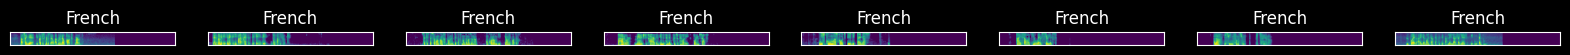

In [10]:
show_images(x_train_arr, y_train)
print(IMAGE_DIMENSIONS)

### Make sure data remains consistent between runs


In [11]:
import hashlib

hash_x_train = hashlib.sha256(str(x_train_arr).encode("utf-8")).hexdigest()
hash_x_test = hashlib.sha256(str(x_test_arr).encode("utf-8")).hexdigest()
hash_y_train = hashlib.sha256(str(y_train_encoded).encode("utf-8")).hexdigest()
hash_y_test = hashlib.sha256(str(y_test_encoded).encode("utf-8")).hexdigest()

# set this to false if you want it to remain consistent run-to-run
# for experimentation and modification without being stopped, set to true
update_hash = True

if update_hash:
    with open("./hashes/hash_x_train.txt", "w") as f:
        f.write(hash_x_train)
    with open("./hashes/hash_x_test.txt", "w") as f:
        f.write(hash_x_test)
    with open("./hashes/hash_y_train.txt", "w") as f:
        f.write(hash_y_train)
    with open("./hashes/hash_y_test.txt", "w") as f:
        f.write(hash_y_test)

with open("./hashes/hash_x_train.txt", "r") as f:
    expected_hash_x_train = f.read()
with open("./hashes/hash_x_test.txt", "r") as f:
    expected_hash_x_test = f.read()
with open("./hashes/hash_y_train.txt", "r") as f:
    expected_hash_y_train = f.read()
with open("./hashes/hash_y_test.txt", "r") as f:
    expected_hash_y_test = f.read()

# Check if the computed hashes match the expected values
assert (
    hash_x_train == expected_hash_x_train
), f"Hash of x does not match the expected value: {expected_hash_x_train}"
assert (
    hash_x_test == expected_hash_x_test
), f"Hash of x does not match the expected value: {expected_hash_x_test}"
assert (
    hash_y_train == expected_hash_y_train
), f"Hash of y does not match the expected value: {expected_hash_y_train}"
assert (
    hash_y_test == expected_hash_y_test
), f"Hash of y does not match the expected value: {expected_hash_y_test}"
print("OK")

OK


## Models


In [12]:
from keras.models import Model, Sequential
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Input,
    TimeDistributed,
    GRU,
)

In [13]:
# sequentialModel = Sequential()
# sequentialModel.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMAGE_DIMENSIONS)))
# sequentialModel.add(MaxPooling2D(2, 2))
# sequentialModel.add(Conv2D(128, (3, 3), activation="relu"))
# sequentialModel.add(MaxPooling2D(2, 2))
# sequentialModel.add(Conv2D(128, (3, 3), activation="relu"))
# sequentialModel.add(MaxPooling2D(2, 2))
# sequentialModel.add(Conv2D(128, (3, 3), activation="relu"))
# sequentialModel.add(MaxPooling2D(2, 2))
# sequentialModel.add(Flatten())
# sequentialModel.add(Dense(1024, activation="relu"))
# sequentialModel.add(Dense(len(langs), activation="softmax"))
sequentialModel = Sequential()
sequentialModel.add(
    Conv2D(32, (3, 3), activation="relu", strides=(1, 1), input_shape=IMAGE_DIMENSIONS)
)
sequentialModel.add(Conv2D(64, (3, 3), activation="relu", strides=(1, 2)))
sequentialModel.add(Conv2D(64, (3, 3), activation="relu", strides=(1, 1)))
sequentialModel.add(Conv2D(128, (1, 3), activation="relu", strides=(1, 2)))
sequentialModel.add(Flatten())
sequentialModel.add(Dense(1024, activation="relu"))
sequentialModel.add(Dropout(0.5))
sequentialModel.add(Dense(len(langs), activation="softmax"))


seqOpt = tf.keras.optimizers.legacy.Nadam(learning_rate=1e-3)
sequentialModel.compile(
    optimizer=seqOpt, loss="categorical_crossentropy", metrics=["accuracy"]
)
sequentialModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 248, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 123, 64)       18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 121, 64)       36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 60, 128)       24704     
                                                                 
 flatten (Flatten)           (None, 107520)            0         
                                                                 
 dense (Dense)               (None, 1024)              110101504 
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [14]:
# architecture from
# https://github.com/pietz/language-recognition/blob/master/Language%20Classifier.ipynb
in_dim = IMAGE_DIMENSIONS  # 13x1000 grayscale images (1 color channel)

i = Input(shape=in_dim)
m = Conv2D(16, (3, 3), activation="elu", padding="same")(i)
m = MaxPooling2D()(m)
m = Conv2D(32, (3, 3), activation="elu", padding="same")(m)
m = MaxPooling2D()(m)
m = Conv2D(64, (3, 3), activation="elu", padding="same")(m)
# m = MaxPooling2D()(m)
m = Conv2D(128, (3, 3), activation="elu", padding="same")(m)
# m = MaxPooling2D()(m)
m = Conv2D(256, (3, 3), activation="elu", padding="same")(m)
# m = MaxPooling2D()(m)
m = Flatten()(m)
m = Dense(512, activation="elu")(m)
m = Dropout(0.5)(m)
o = Dense(len(langs), activation="softmax")(m)

githubModel = Model(inputs=i, outputs=o)

gitOpt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
githubModel.compile(
    loss="categorical_crossentropy", optimizer=gitOpt, metrics=["accuracy"]
)
githubModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 250, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 250, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 125, 16)       0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 125, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 62, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 62, 64)         18496 

In [ ]:
# THIS MODEL USED
# architecture heavily borrowed from
# https://github.com/pietz/language-recognition/blob/master/Language%20Classifier.ipynb
IMAGE_DIMENSIONS = (13, 250, 1)
i = Input(shape=IMAGE_DIMENSIONS)
m = Conv2D(16, (3, 3), activation="elu", padding="same")(i)
m = MaxPooling2D()(m)
m = Conv2D(32, (3, 3), activation="elu", padding="same")(m)
m = MaxPooling2D()(m)
m = Conv2D(64, (2, 3), activation="elu", padding="same")(m)
m = MaxPooling2D()(m)
m = Conv2D(128, (1, 3), activation="elu", padding="same")(m)
m = Flatten()(m)
m = Dense(512, activation="elu")(m)
m = Flatten()(m)
m = Dropout(0.5)(m)
o = Dense(len(langs), activation="softmax")(m)

cnn = Model(inputs=i, outputs=o)

cnopt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
cnn.compile(loss="categorical_crossentropy", optimizer=cnopt, metrics=["accuracy"])
cnn.summary()

In [28]:
# v2 test
# modifications of my own design
IMAGE_DIMENSIONS = (20, 250, 1)
i = Input(shape=IMAGE_DIMENSIONS)
m = Conv2D(16, (1, 3), activation="elu", padding="same")(i)
m = MaxPooling2D((1, 2))(m)
m = Conv2D(32, (1, 3), activation="elu", padding="same")(m)
m = MaxPooling2D((1, 2))(m)
m = Conv2D(64, (1, 3), activation="elu", padding="same")(m)
m = MaxPooling2D()(m)
m = Conv2D(128, (1, 3), activation="elu", padding="same")(m)
m = MaxPooling2D()(m)
m = Conv2D(256, (1, 3), activation="elu", padding="same")(m)
m = MaxPooling2D()(m)
m = Flatten()(m)
m = Dense(512, activation="elu")(m)
m = Dropout(0.5)(m)
o = Dense(len(langs), activation="softmax")(m)

cnn_v2_test = Model(inputs=i, outputs=o)

cnopt_v2_test = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
cnn_v2_test.compile(
    loss="categorical_crossentropy", optimizer=cnopt_v2_test, metrics=["accuracy"]
)
cnn_v2_test.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 20, 250, 1)]      0         
                                                                 
 conv2d_49 (Conv2D)          (None, 20, 250, 16)       64        
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 20, 125, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 20, 125, 32)       1568      
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 20, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 20, 62, 64)        6208

In [18]:
# Define the spectrogram shape at the input
# input_shape = IMAGE_DIMENSIONS  # 13 - height, 1000 - width, 1 - grayscale

# Create a Sequential model
model = Sequential()

# Add 2D convolution layer
model.add(
    Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=IMAGE_DIMENSIONS)
)

model.add(MaxPooling2D(pool_size=(2, 2)))

# dropout layer for regularization
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

# add GRU layer
model.add(GRU(128, return_sequences=False))

model.add(Dropout(0.5))

model.add(Dense(len(langs), activation="softmax"))
opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3) # last tested on 1e-4, got like 1 for loss
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 18, 248, 32)       320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 9, 124, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 9, 124, 32)        0         
                                                                 
 time_distributed (TimeDist  (None, 9, 3968)           0         
 ributed)                                                        
                                                                 
 gru (GRU)                   (None, 128)               1573632   
                                                                 
 dropout_4 (Dropout)         (None, 128)              

In [ ]:
# taken directly from
# https://github.com/sergeyvilov/MCV-spoken-language-recognition/blob/master/audio_models.py
# not used

import tensorflow as tf
from tensorflow.keras import layers, models
from torch import dropout


class CRNN(models.Model):
    def __init__(
        self,
        n_languages=len(langs),
        input_height=20,
        lstm_layers=2,
        dropout=0.25,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.image_height = input_height
        self.lstm_layers = lstm_layers
        self.lstm_hout = 128
        self.dropout = dropout
        self.n_languages = n_languages

        # Convolutional layers, note that 'padding=same' ensures the output has the same dimension as the input.
        self.conv1 = layers.Conv2D(10, kernel_size=(1, 5), padding="same")
        self.bn1 = layers.BatchNormalization()

        self.conv2 = layers.Conv2D(1, kernel_size=(1, 5), padding="same")
        self.bn2 = layers.BatchNormalization()

        # LSTM Layer, note that return_sequences is set to True to return the full sequence.
        self.rnn = layers.Bidirectional(
            layers.LSTM(self.lstm_hout, return_sequences=True, dropout=dropout),
            merge_mode="concat",
        )

        # Fully connected layers
        self.fc1 = layers.Dense(32)
        self.fc3 = layers.Dense(32)
        self.fc4 = layers.Dense(self.n_languages)

    def build(self, input_shape):
        # Define the RNN and FC layers now that we have the input_shape
        self.input_shape = input_shape[1:]  # Exclude the batch dimension
        # Compute the number of features after Conv2D layers
        lstm_input_dim = self.input_shape[0] * self.input_shape[2]

        # LSTM Layer
        self.rnn = layers.Bidirectional(
            layers.LSTM(
                self.lstm_hout,
                return_sequences=True,
                dropout=dropout,
            ),
            merge_mode="concat",
        )

        # Fully connected layers
        self.fc1 = layers.Dense(32)
        self.fc3 = layers.Dense(32)
        self.fc4 = layers.Dense(self.n_languages)

        super().build(input_shape)

    def call(self, x):
        # Add a dimension equivalent to channels at the start (N_batch, Channels, Height, Width)
        x = tf.expand_dims(x, axis=-1)

        # Apply convolutional layers
        out = self.conv1(x)
        out = self.bn1(out)
        out = tf.nn.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = tf.nn.relu(out)

        # Reshaping to (batch_size, sequence, features) before applying RNN
        out = tf.reshape(out, (tf.shape(out)[0], tf.shape(out)[2], -1))  # type: ignore

        # Apply RNN layer
        out = self.rnn(out)

        # Flattening is not always necessary before a Dense layer, because the Dense layer can handle multi-dimensional inputs

        # Apply fully connected layers
        out = self.fc1(out)
        out = tf.nn.relu(out)
        out = tf.nn.dropout(out, rate=self.dropout)

        out = self.fc3(out)
        out = tf.nn.relu(out)
        out = tf.nn.dropout(out, rate=self.dropout)

        out = self.fc4(out)

        return out


# Usage
crnn_model = CRNN(n_languages=len(langs), input_height=13, lstm_layers=2, dropout=0.25)
crnn_opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
crnn_model.compile(
    optimizer=crnn_opt, loss="categorical_crossentropy", metrics=["accuracy"]
)
print(IMAGE_DIMENSIONS)
crnn_model.build((32, 1, IMAGE_DIMENSIONS[2], IMAGE_DIMENSIONS[1]))
crnn_model.summary()

In [ ]:
print(x_train_arr.shape)
crnn_model.fit(
    x_train_arr,
    y_train_encoded,
    validation_data=(x_test_arr, y_test_encoded),
    batch_size=32,
    epochs=10,
)

In [ ]:
rnn = Sequential()

rnn.add(
    GRU(
        256,
        return_sequences=True,
        input_shape=(IMAGE_DIMENSIONS[0], IMAGE_DIMENSIONS[1]),
    )
)
rnn.add(GRU(256, return_sequences=True))
rnn.add(GRU(256))

# Add a fully connected layer
rnn.add(Dense(256, activation="relu"))
rnn.add(Dense(256, activation="relu"))

# Output Layer - softmax activation function for multi-class classification
rnn.add(Dense(len(langs), activation="softmax"))

# Compile the model
rnn.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 13, 256)           390144    
                                                                 
 gru_2 (GRU)                 (None, 13, 256)           394752    
                                                                 
 gru_3 (GRU)                 (None, 256)               394752    
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 1312517 (5.01 MB)
Trainable params: 1312

In [ ]:
"""
:author:
Paul Bethge (bethge@zkm.de)
2021

:License:
This package is published under Simplified BSD License.
"""

# https://github.com/douglas125/SpeechCmdRecognition/blob/master/SpeechModels.py

from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Input, Dense, LSTM, Conv2D, Bidirectional
from tensorflow.keras.layers import Lambda, Dot, Softmax
from tensorflow.keras.models import Model

import tensorflow.keras.backend as K

# from src.utils.training_utils import get_feature_layer


def create_model():
    """
    This code is heavily borrowed from <https://github.com/douglas125/SpeechCmdRecognition>.
    """
    # inputs = Input((IMAGE_DIMENSIONS[1], IMAGE_DIMENSIONS[0], 1), name="input")
    # height, length, channels
    i = Input(shape=IMAGE_DIMENSIONS, name="input")
    x = BatchNormalization()(i)

    x = Conv2D(10, (5, 1), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, (5, 1), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)

    x = Lambda(lambda q: K.squeeze(q, -1), name="squeeze_last_dim")(x)

    x = Bidirectional(LSTM(64, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]
    x = Bidirectional(LSTM(64, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]

    xFirst = Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    query = Dense(128)(xFirst)

    # dot product attention
    attScores = Dot(axes=[1, 2])([query, x])
    attScores = Softmax(name="attSoftmax")(attScores)  # [b_s, seq_len]

    # rescale sequence
    attVector = Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

    x = Dense(64, activation="relu")(attVector)
    # x = Dropout(0.25)(x)
    x = Dense(32)(x)
    # x = Dropout(0.25)(x)

    output = Dense(len(langs), activation="softmax", name="output")(x)

    model = Model(inputs=[i], outputs=[output])

    return model


attrnn = create_model()
attrnn_opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
attrnn.compile(
    optimizer=attrnn_opt,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
print(attrnn.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 13, 250, 1)]         0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 13, 250, 1)           4         ['input[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 conv2d_14 (Conv2D)          (None, 13, 250, 10)          60        ['batch_normalization[0][0]'] 
                                                                                                  
 batch_normalization_1 (Bat  (None, 13, 250, 10)          40        ['conv2d_14[0][0]']     

In [ ]:
#https://github.com/sergeyvilov/MCV-spoken-language-recognition/blob/master/audio_models.py
import torch
import torch.nn as nn


class CRNN(nn.Module):
    def __init__(
        self,
        device,
        n_languages=5,
        input_height=20,
        lstm_layers=2,
        dropout=0.25,
        **kwargs
    ):
        """
        Convolutional RNN with the same number of parameters as above attention RNN
        """

        super().__init__()

        self.device = device

        self.image_height = input_height

        self.lstm_layers = lstm_layers
        self.lstm_hout = 128

        # input size: N_batch x 1 x image_height x L

        self.conv1 = nn.Conv2d(
            1, 10, kernel_size=(1, 5), padding="same"
        )  # conv only in time dimension
        self.bn1 = nn.BatchNorm2d(10)

        self.conv2 = nn.Conv2d(
            10, 1, kernel_size=(1, 5), padding="same"
        )  # conv only in time dimension
        self.bn2 = nn.BatchNorm2d(1)

        # convert dimensions to N_batch x L x image_height here!

        self.rnn = nn.LSTM(
            self.image_height,
            self.lstm_hout,
            self.lstm_layers,
            bidirectional=True,
            batch_first=True,
        )  # Hin, Hout

        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()

        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.LazyLinear(32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, n_languages)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)

        n_batch = x.shape[0]

        h0 = torch.zeros(2 * self.lstm_layers, n_batch, self.lstm_hout).to(self.device)
        c0 = torch.zeros(2 * self.lstm_layers, n_batch, self.lstm_hout).to(self.device)

        out = self.conv1(x)
        out = self.bn1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = torch.permute(
            out, (0, 3, 2, 1)
        ).squeeze()  # remove last singleton dimension

        out, (hn, cn) = self.rnn(out, (h0, c0))

        out = self.flatten(out)

        out = self.fc1(out)
        out = self.relu(out)

        out = self.dropout(out)

        out = self.fc3(out)
        out = self.relu(out)

        out = self.dropout(out)

        out = self.fc4(out)

        return out

# set device, use mps if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = CRNN(image_height=IMAGE_DIMENSIONS[0], device=device).to(device)

# input = torch.randn(3, 20, 13).to(device) #N_batch x 1 x image_height x L

model().shape

## Train


In [ ]:
from keras.callbacks import EarlyStopping

earlyStopping = EarlyStopping(
    monitor="val_loss", patience=4, verbose=0, mode="min", restore_best_weights=True
)
# specify models to train
seq = {
    "model": sequentialModel,
    "name": "sequential",
    "epochs": 10,
    "batch_size": 8,
}
git = {
    "model": githubModel,
    "name": "github",
    "epochs": 10,
    "batch_size": 16,
}
crnn = {
    "model": model,
    "name": "crnn",
    "epochs": 15,
    "batch_size": 16,
}
cnn = {
    "model": cnn,
    "name": "cnn",
    "epochs": 10,
    "batch_size": 32,
}
rnn = {
    "model": rnn,
    "name": "rnn",
    "epochs": 100,
    "batch_size": 64,
}
attrnn = {
    "model": attrnn,
    "name": "attrnn",
    "epochs": 100,
    "batch_size": 64,
}

### Train Models


In [ ]:
# models = [cnn, rnn, crnn, seq, git]
models = [cnn]
histories = []

history = cnn["model"].fit(
    x_train_arr,
    y_train_encoded,
    validation_data=(x_test_arr, y_test_encoded),
    batch_size=cnn["batch_size"],
    epochs=cnn["epochs"],
    verbose=1,
    callbacks=earlyStopping,
)
histories.append((cnn["name"], history))

Epoch 1/10
2899/2899 [==============================] - 80s 27ms/step - loss: 0.6354 - accuracy: 0.7638 - val_loss: 0.6801 - val_accuracy: 0.7484
Epoch 2/10
2899/2899 [==============================] - 95s 33ms/step - loss: 0.6173 - accuracy: 0.7707 - val_loss: 0.6978 - val_accuracy: 0.7452
Epoch 3/10
2899/2899 [==============================] - 75s 26ms/step - loss: 0.6029 - accuracy: 0.7768 - val_loss: 0.7401 - val_accuracy: 0.7440
Epoch 4/10
2899/2899 [==============================] - 96s 33ms/step - loss: 0.5809 - accuracy: 0.7845 - val_loss: 0.6900 - val_accuracy: 0.7546
Epoch 5/10
2899/2899 [==============================] - 94s 33ms/step - loss: 0.5654 - accuracy: 0.7912 - val_loss: 0.7134 - val_accuracy: 0.7455


In [ ]:
cnn["model"].save("cnn.h5")


/Users/thabnir/maisproj/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = tf.keras.models.load_model("cnn.h5")
# test
print("test")
loaded_model.test_on_batch(x_test_arr, y_test_encoded)

# for model_dict in models:
#     print(f"Training {model_dict['name']}")
#     history = model_dict["model"].fit(
#         x_train_arr,
#         y_train_encoded,
#         validation_data=(x_test_arr, y_test_encoded),
#         batch_size=model_dict["batch_size"],
#         epochs=model_dict["epochs"],
#         verbose=1,
#         callbacks=earlyStopping,
#     )
#     histories.append((model_dict["name"], history))
#     print(f"Finished training {model_dict['name']}")

test


[0.6816518902778625, 0.7530515193939209]

## Keras Results


In [ ]:
def plot_accuracy(name, history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "-", label=f"{name} Training Accuracy")
    plt.plot(epochs, val_acc, ":", label=f"{name} Validation Accuracy")
    plt.title(f"{name} Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")
    plt.plot()
    plt.show()


def plot_loss(name, history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, "-", label=f"{name} Training Loss")
    plt.plot(epochs, val_loss, ":", label=f"{name} Validation Loss")
    plt.title(f"{name} Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.plot()
    plt.show()

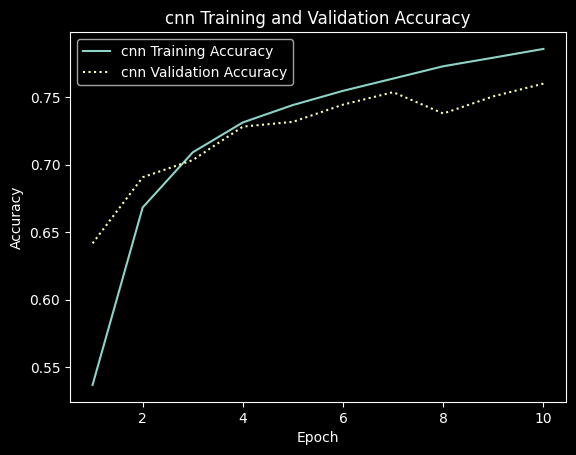

In [ ]:
for history in histories:
    plot_accuracy(name=history[0], history=history[1])

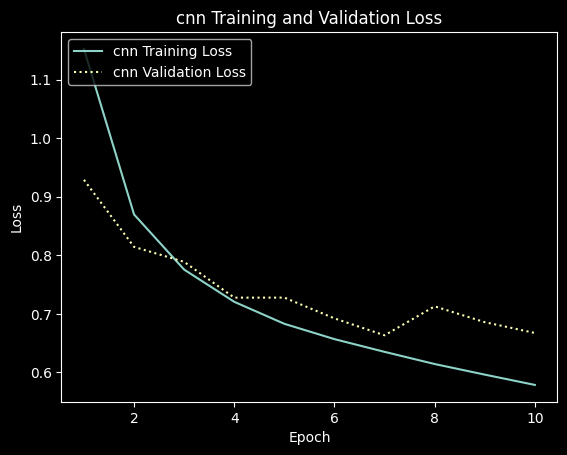

In [ ]:
for history in histories:
    plot_loss(name=history[0], history=history[1])

In [ ]:
for model in models:
    print(f"Saving {model['name']} to {model['name']}_lang_classifier.keras")
    model["model"].save(f"{model['name']}_lang_classifier.keras")

Saving cnn to cnn_lang_classifier.keras


In [ ]:
loss_acc = []
for model in models:
    print(f"Evaluating {model['name']}")
    [loss, accuracy] = model["model"].evaluate(
        x_test_arr, y_test_encoded, verbose=1
    )
    loss_acc.append((model["name"], loss, accuracy))
    print(f"{model['name']} Loss: {loss}")
    print(f"{model['name']} Accuracy: {accuracy * 100:.2f}%")

    # compare to random:
    random_accuracy = 1 / len(langs)
    print(f"Random Accuracy: {random_accuracy * 100:.2f}%")
    print(f"Difference: {(accuracy - random_accuracy) * 100:.2f}%")

Evaluating cnn
2899/2899 [==============================] - 20s 7ms/step - loss: 0.6674 - accuracy: 0.7601
cnn Loss: 0.6673745512962341
cnn Accuracy: 76.01%
Random Accuracy: 20.00%
Difference: 56.01%


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [ ]:
sns.set()
label_encoder = LabelEncoder()
y_preds = []
for model in models:
    y_preds.append(model["model"].predict(x_test_arr))

2899/2899 [==============================] - 20s 7ms/step


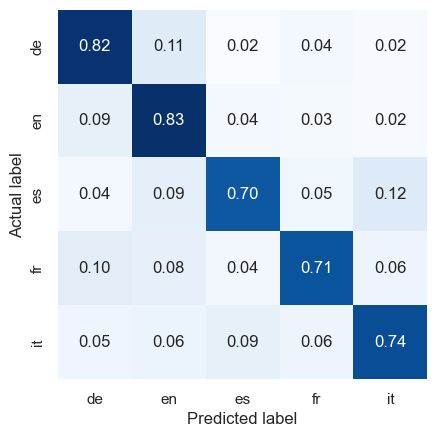

In [ ]:
for y_predicted in y_preds:
    test = label_encoder.fit_transform(
        y_test_encoded.argmax(axis=1)
    )  # Replace y_test with your actual labels
    pred = label_encoder.transform(y_predicted.argmax(axis=1))

    mat = confusion_matrix(test, pred, normalize="true")

    sns.heatmap(
        mat,
        square=True,
        annot=True,
        fmt=".2f",
        cbar=False,
        cmap="Blues",
        xticklabels=langs,
        yticklabels=langs,
    )

    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")
    plt.show()